In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dirty_completeness import *

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression, RidgeClassifier, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
seed = 42

In [4]:
cancer_data = pd.read_csv('cancer.csv')
cancer_data.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [8]:
cancer_data.columns

Index(['Clump_Thickness', 'Uniformity_of_Cell_Size',
       'Uniformity_of_Cell_Shape', 'Marginal_Adhesion',
       'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin',
       'Normal_Nucleoli', 'Mitoses', 'Class'],
      dtype='object')

In [5]:
# Injection of missing values
dirty_cancer = injection(df_pandas=cancer_data, seed=seed,name="cancer", name_class="Class")

In [6]:
def get_full_score(classifier, X_full, y_full):
    impute_scores = cross_val_score(
        classifier, X_full, y_full, scoring="accuracy", cv=4
    )
    return impute_scores.mean(), impute_scores.std()

In [8]:
# Logistic Regression with complete data
classifier = LogisticRegression()

X_full = cancer_data.drop("Class", axis=1)
y_full = cancer_data["Class"]
acc_original, std_original = get_full_score(classifier, X_full, y_full)

In [9]:
class Imputation:
    def __init__(self, name, classifier, imputer):
        self.name = name
        self.classifier = classifier
        self.imputer = imputer
        self.estimator = make_pipeline(self.imputer, self.classifier)
        self.accs = []
        self.stds = []
        self.accs_assessment = []
        self.y_labels = ["50%", "40%", "30%", "20%", "10%"]

    def accuracy_assessment(self, X_missing, X_full):
        # Accuracy assessment of imputation

        # Generate the imputed data (first 9 columns) and the indicator matrix (last 9 columns),
        # where 1 indicates that the value was missing
        injected_indicator = self.imputer.fit_transform(X_missing)
        num_cols = X_missing.shape[1]
        # Extract the imputed data
        injected_array = injected_indicator[:, :num_cols]
        # Extract the indicator matrix
        indicator_matrix = injected_indicator[:, num_cols:]
        # Extract from injected_array the values in the same position of the indicator matrix
        # that are equal to 1
        injected_values = injected_array[indicator_matrix == 1]
        # Extract the original values
        original_values = X_full.values[indicator_matrix == 1]
        # MSE between the original values and the injected values
        mse = np.mean((original_values - injected_values)**2)
        
        return mse

    def get_scores_for_single_dataset(self, X_missing, y_missing, X_full):
        # Accuracy of the classifier with imputated data
        impute_scores = cross_val_score(
            self.estimator, X_missing, y_missing, scoring="accuracy", cv=4
        )
        # Accuracy assessment of imputation
        mse = self.accuracy_assessment(X_missing, X_full)

        mean_score = np.mean(impute_scores)
        std_score = np.std(impute_scores)

        self.accs.append(mean_score)
        self.stds.append(std_score)
        self.accs_assessment.append(mse)

        return mean_score, std_score, mse

    def get_scores_for_full_dataset(self, original_dataset, dirty_dataset):
        # Accuracy of the classifier with imputated data
        for dirty_df in dirty_dataset:
            X_missing = dirty_df.drop("Class", axis=1)
            y_missing = dirty_df["Class"]
            X_full = original_dataset.drop("Class", axis=1)
            self.get_scores_for_single_dataset(X_missing, y_missing, X_full)

        return self.accs, self.stds, self.accs_assessment

    # Print the accuracy of the classifier with imputated data and the accuracy assessment of imputation
    def print_imputation(self, acc_original, std_original):
        print("Accuracy of the classifier with complete data: {:.3f} ± {:.3f}".format(acc_original, std_original))
        print()
        for i in range(len(self.accs)):
            print(
                "Accuracy of the classifier with imputated data with "
                + self.y_labels[i]
                + " missing values: {:.3f} ± {:.3f}".format(self.accs[i], self.stds[i])
            )
        print()
        for i in range(len(self.accs_assessment)):
            print(
                "MSE between original values and imputed ones with "
                + self.y_labels[i]
                + " missing values: {:.3f}".format(self.accs_assessment[i])
            )

    def plot_imputation(self, acc_original, std_original):
        colors = ["r", "g", "b", "orange", "black"]

        plt.figure(figsize=(12, 6))
        
        ax1 = plt.subplot(121)
        ax1.barh(
            "Original",
            acc_original,
            xerr=std_original,
            color="purple",
            label="Original",
            alpha=0.6,
            align="center",
        )
        for j in range(len(self.accs)):
            ax1.barh(
                self.y_labels[j],
                self.accs[j],
                xerr=self.stds[j],
                color=colors[j],
                label=self.y_labels[j],
                alpha=0.6,
                align="center",
            )

        ax1.set_xlabel("Accuracy")
        ax1.set_ylabel("Percentage of missing values")
        ax1.set_xlim(left=np.min(self.accs) - 0.1, right=1)
        ax1.invert_yaxis()

        ax2 = plt.subplot(122)
        for j in range(len(self.accs_assessment)):
            ax2.barh(
                self.y_labels[j],
                self.accs_assessment[j],
                color=colors[j],
                label=self.y_labels[j],
                alpha=0.6,
                align="center",
            )

        ax2.set_xlabel("MSE")
        ax2.set_xlim(left=np.min(self.accs_assessment) * 0.9, right=np.max(self.accs_assessment) * 1.1)
        ax2.invert_yaxis()

        plt.suptitle("Imputation of missing values with " + self.name)
        plt.tight_layout()
        plt.show()

    def plot_imputation_errorbar(self):
        # Plot the accuracy of the classifier with imputated data
        plt.figure(figsize=(8, 6))
        plt.errorbar(
            self.y_labels,
            self.accs,
            yerr=self.stds,
            fmt="o",
            capsize=5,
            capthick=2,
            ecolor="red",
            elinewidth=3,
            color="blue",
            label="Accuracy of the classifier with imputated data",
        )
        plt.xlabel("Percentage of missing values")
        plt.ylabel("Accuracy")
        plt.title("Imputation of missing values with " + self.name)
        plt.legend()
        plt.show()

        # Plot the accuracy assessment of imputation
        plt.figure(figsize=(8, 6))
        plt.errorbar(
            self.y_labels,
            self.accs_assessment,
            fmt="o",
            capsize=5,
            capthick=2,
            ecolor="red",
            elinewidth=3,
            color="blue",
            label="Accuracy assessment of imputation",
        )
        plt.xlabel("Percentage of missing values")
        plt.ylabel("MSE")
        plt.title("Imputation of missing values with " + self.name)
        plt.legend()
        plt.show()

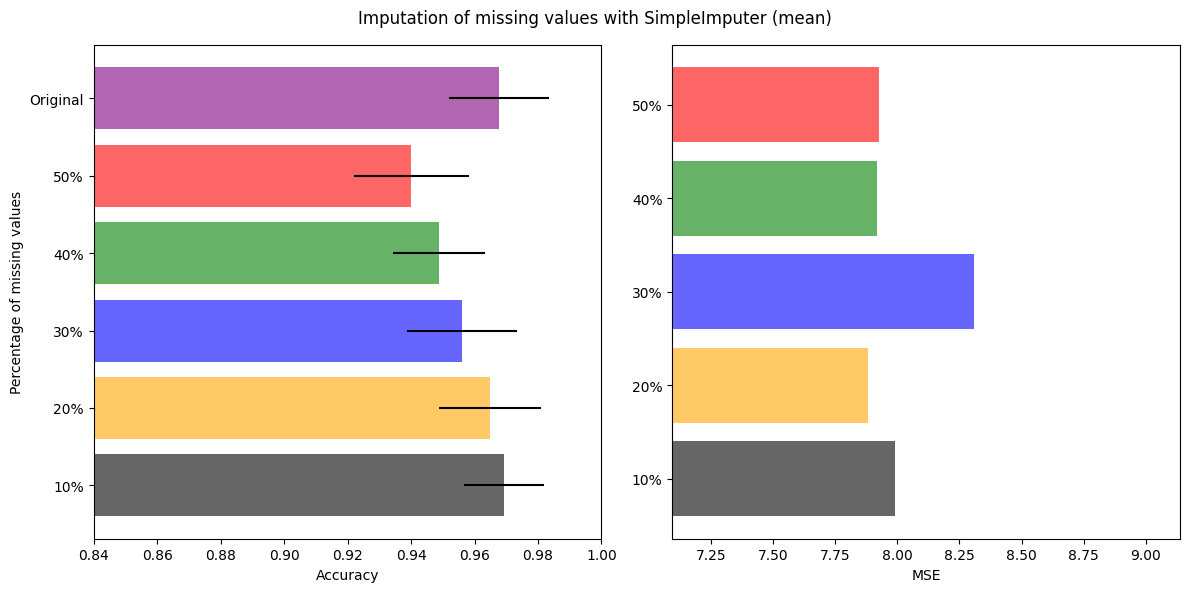

Accuracy of the classifier with complete data: 0.968 ± 0.016

Accuracy of the classifier with imputated data with 50% missing values: 0.940 ± 0.018
Accuracy of the classifier with imputated data with 40% missing values: 0.949 ± 0.015
Accuracy of the classifier with imputated data with 30% missing values: 0.956 ± 0.017
Accuracy of the classifier with imputated data with 20% missing values: 0.965 ± 0.016
Accuracy of the classifier with imputated data with 10% missing values: 0.969 ± 0.013

MSE between original values and imputed ones with 50% missing values: 7.928
MSE between original values and imputed ones with 40% missing values: 7.919
MSE between original values and imputed ones with 30% missing values: 8.307
MSE between original values and imputed ones with 20% missing values: 7.883
MSE between original values and imputed ones with 10% missing values: 7.991


In [11]:
# Imputation with SimpleImputer (mean)
imputer = SimpleImputer(strategy="mean", add_indicator=True)
classifier = LogisticRegression()
imputation_mean = Imputation("SimpleImputer (mean)", classifier, imputer)
imputation_mean.get_scores_for_full_dataset(cancer_data, dirty_cancer)
imputation_mean.plot_imputation(acc_original, std_original)
imputation_mean.print_imputation(acc_original, std_original)

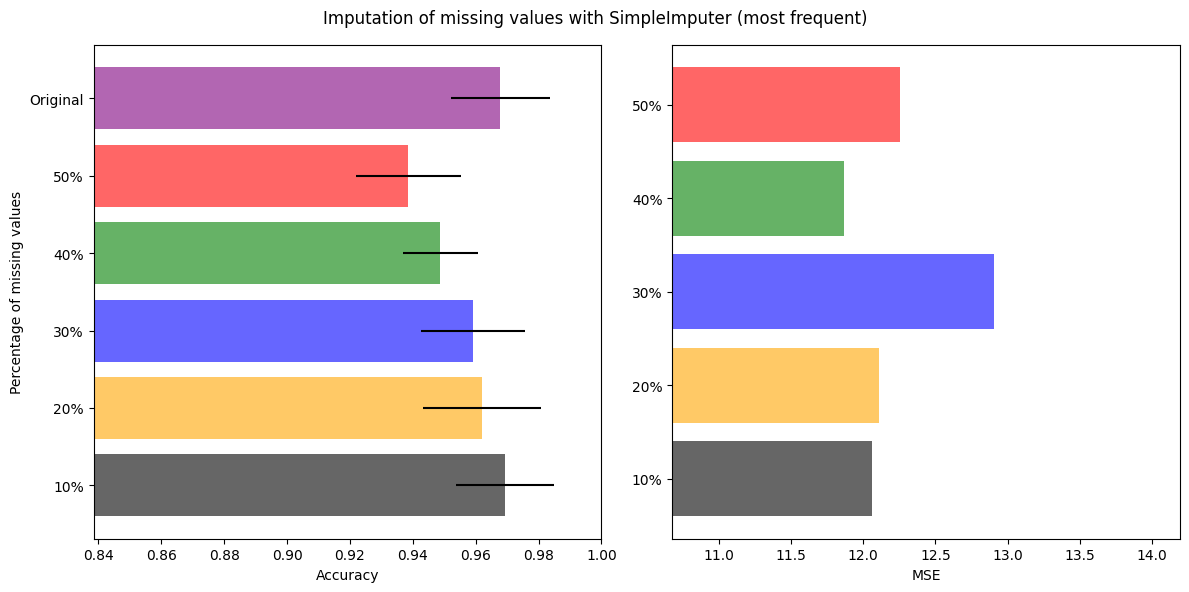

Accuracy of the classifier with complete data: 0.968 ± 0.016

Accuracy of the classifier with imputated data with 50% missing values: 0.939 ± 0.017
Accuracy of the classifier with imputated data with 40% missing values: 0.949 ± 0.012
Accuracy of the classifier with imputated data with 30% missing values: 0.959 ± 0.017
Accuracy of the classifier with imputated data with 20% missing values: 0.962 ± 0.019
Accuracy of the classifier with imputated data with 10% missing values: 0.969 ± 0.016

MSE between original values and imputed ones with 50% missing values: 12.253
MSE between original values and imputed ones with 40% missing values: 11.866
MSE between original values and imputed ones with 30% missing values: 12.902
MSE between original values and imputed ones with 20% missing values: 12.108
MSE between original values and imputed ones with 10% missing values: 12.063


In [12]:
# Imputation with SimpleImputer (most frequent)
imputer = SimpleImputer(strategy="most_frequent", add_indicator=True)
classifier = LogisticRegression()
imputation_most_frequent = Imputation("SimpleImputer (most frequent)", classifier, imputer)
imputation_most_frequent.get_scores_for_full_dataset(cancer_data, dirty_cancer)
imputation_most_frequent.plot_imputation(acc_original, std_original)
imputation_most_frequent.print_imputation(acc_original, std_original)

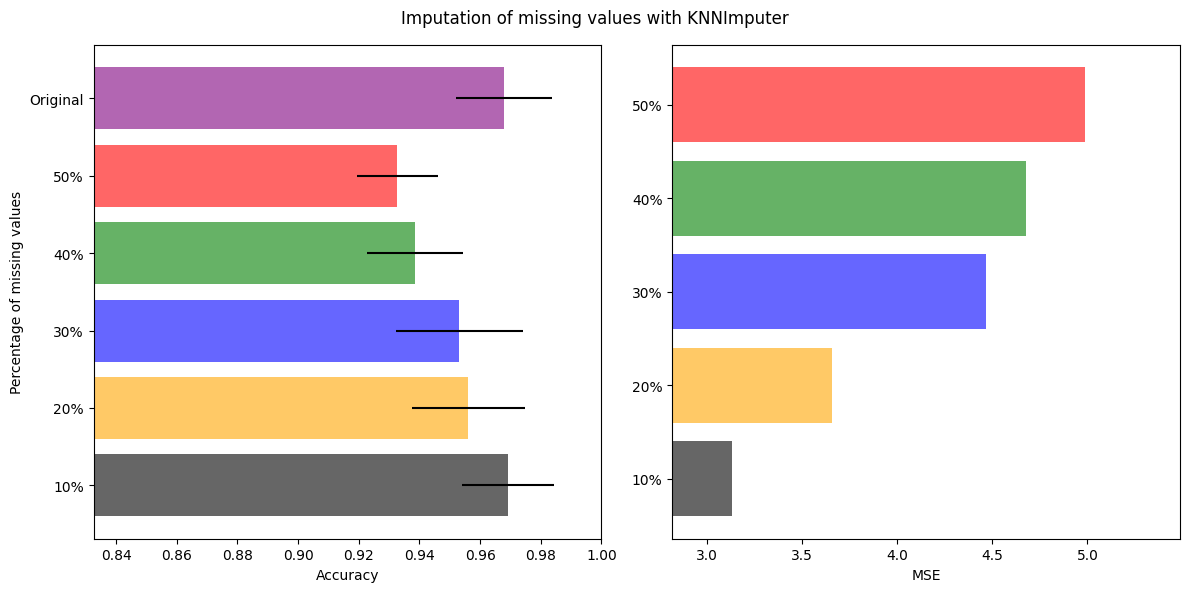

Accuracy of the classifier with complete data: 0.968 ± 0.016

Accuracy of the classifier with imputated data with 50% missing values: 0.933 ± 0.013
Accuracy of the classifier with imputated data with 40% missing values: 0.939 ± 0.016
Accuracy of the classifier with imputated data with 30% missing values: 0.953 ± 0.021
Accuracy of the classifier with imputated data with 20% missing values: 0.956 ± 0.019
Accuracy of the classifier with imputated data with 10% missing values: 0.969 ± 0.015

MSE between original values and imputed ones with 50% missing values: 4.988
MSE between original values and imputed ones with 40% missing values: 4.675
MSE between original values and imputed ones with 30% missing values: 4.466
MSE between original values and imputed ones with 20% missing values: 3.659
MSE between original values and imputed ones with 10% missing values: 3.131


In [13]:
# Imputation with KNNImputer
imputer = KNNImputer(n_neighbors=5, add_indicator=True)
classifier = LogisticRegression()
imputation_knn = Imputation("KNNImputer", classifier, imputer)
imputation_knn.get_scores_for_full_dataset(cancer_data, dirty_cancer)
imputation_knn.plot_imputation(acc_original, std_original)
imputation_knn.print_imputation(acc_original, std_original)

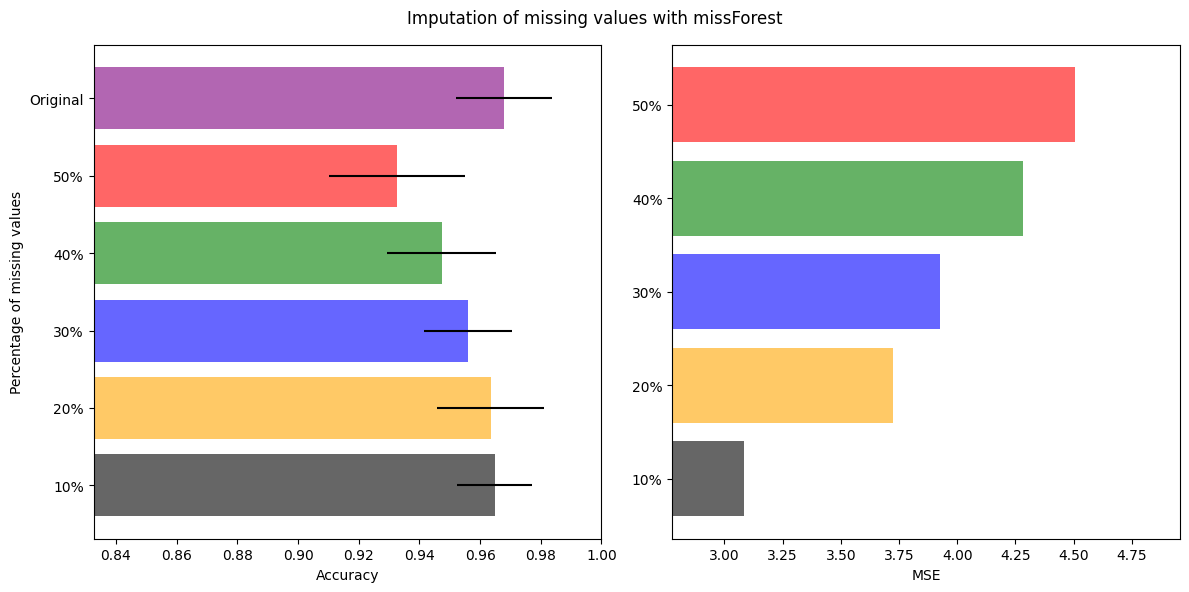

Accuracy of the classifier with complete data: 0.968 ± 0.016

Accuracy of the classifier with imputated data with 50% missing values: 0.933 ± 0.022
Accuracy of the classifier with imputated data with 40% missing values: 0.947 ± 0.018
Accuracy of the classifier with imputated data with 30% missing values: 0.956 ± 0.015
Accuracy of the classifier with imputated data with 20% missing values: 0.963 ± 0.018
Accuracy of the classifier with imputated data with 10% missing values: 0.965 ± 0.012

MSE between original values and imputed ones with 50% missing values: 4.506
MSE between original values and imputed ones with 40% missing values: 4.283
MSE between original values and imputed ones with 30% missing values: 3.925
MSE between original values and imputed ones with 20% missing values: 3.724
MSE between original values and imputed ones with 10% missing values: 3.085


In [15]:
# Imputation with missForest
estimator = RandomForestRegressor(
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=seed,
)
imputer = IterativeImputer(random_state=seed, estimator=estimator, add_indicator=True)
classifier = LogisticRegression()
imputation_missforest = Imputation("missForest", classifier, imputer)
imputation_missforest.get_scores_for_full_dataset(cancer_data, dirty_cancer)
imputation_missforest.plot_imputation(acc_original, std_original)
imputation_missforest.print_imputation(acc_original, std_original)

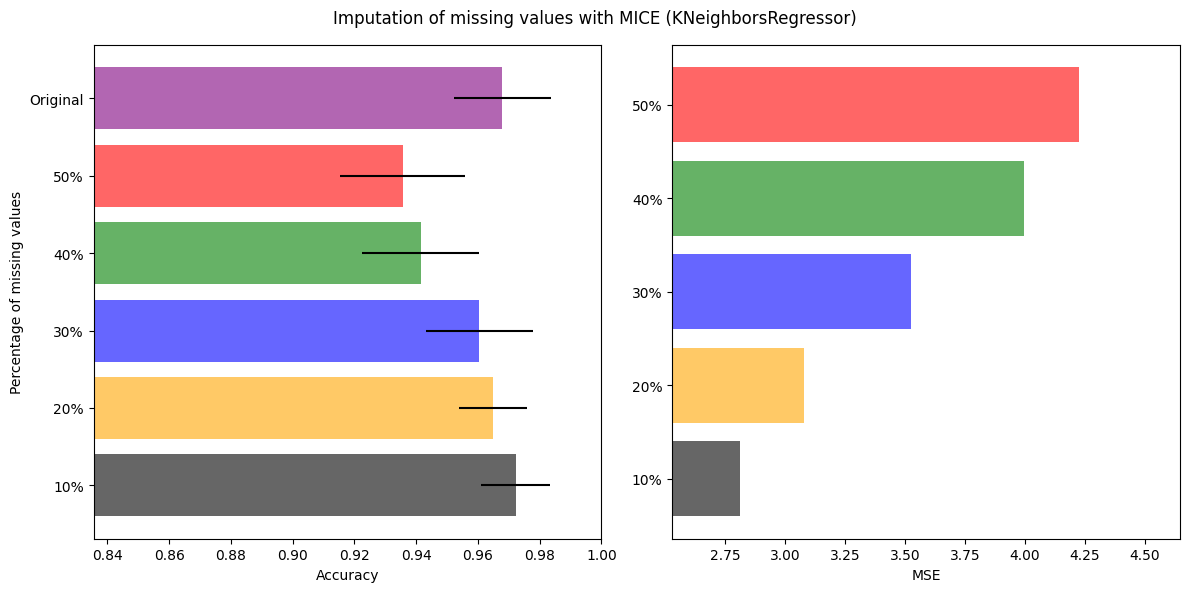

Accuracy of the classifier with complete data: 0.968 ± 0.016

Accuracy of the classifier with imputated data with 50% missing values: 0.936 ± 0.020
Accuracy of the classifier with imputated data with 40% missing values: 0.941 ± 0.019
Accuracy of the classifier with imputated data with 30% missing values: 0.960 ± 0.017
Accuracy of the classifier with imputated data with 20% missing values: 0.965 ± 0.011
Accuracy of the classifier with imputated data with 10% missing values: 0.972 ± 0.011

MSE between original values and imputed ones with 50% missing values: 4.224
MSE between original values and imputed ones with 40% missing values: 3.995
MSE between original values and imputed ones with 30% missing values: 3.523
MSE between original values and imputed ones with 20% missing values: 3.079
MSE between original values and imputed ones with 10% missing values: 2.811


In [22]:
# Imputation with MICE (KNeighborsRegressor)
estimator = KNeighborsRegressor(n_neighbors=10)
imputer = IterativeImputer(random_state=seed, estimator=estimator, add_indicator=True)
classifier = LogisticRegression()
imputation_mice_knr = Imputation("MICE (KNeighborsRegressor)", classifier, imputer)
imputation_mice_knr.get_scores_for_full_dataset(cancer_data, dirty_cancer)
imputation_mice_knr.plot_imputation(acc_original, std_original)
imputation_mice_knr.print_imputation(acc_original, std_original)

In [25]:
# SVC on the original dataset
classifier = SVC()
X_full = cancer_data.drop("Class", axis=1)
y_full = cancer_data["Class"]
acc_original, std_original = get_full_score(classifier, X_full, y_full)

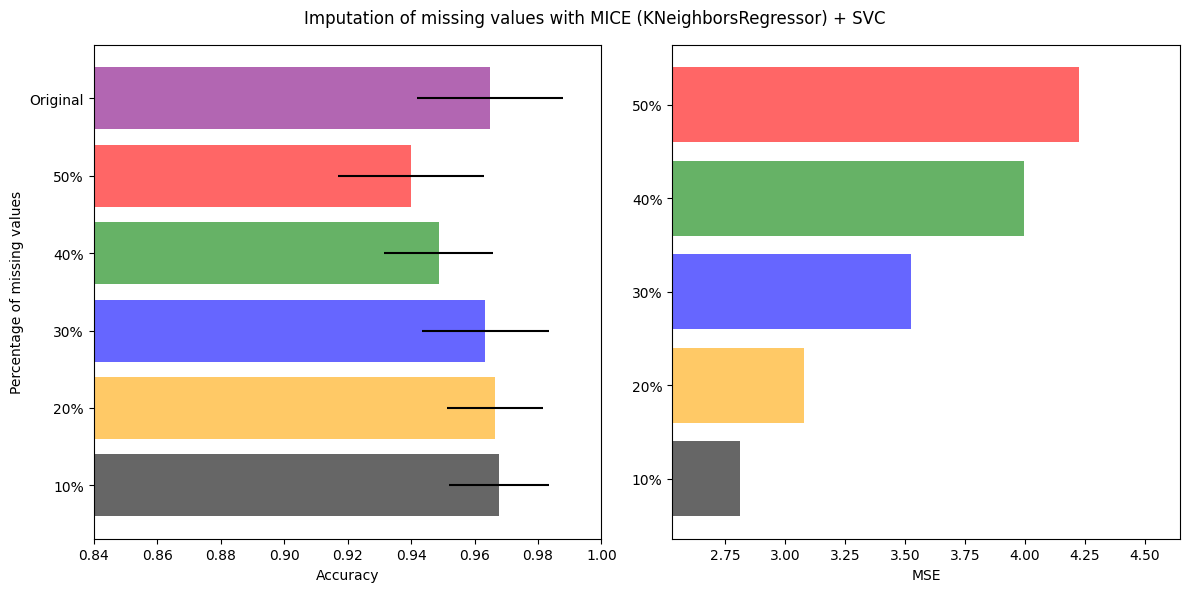

Accuracy of the classifier with complete data: 0.965 ± 0.023

Accuracy of the classifier with imputated data with 50% missing values: 0.940 ± 0.023
Accuracy of the classifier with imputated data with 40% missing values: 0.949 ± 0.017
Accuracy of the classifier with imputated data with 30% missing values: 0.963 ± 0.020
Accuracy of the classifier with imputated data with 20% missing values: 0.966 ± 0.015
Accuracy of the classifier with imputated data with 10% missing values: 0.968 ± 0.016

MSE between original values and imputed ones with 50% missing values: 4.224
MSE between original values and imputed ones with 40% missing values: 3.995
MSE between original values and imputed ones with 30% missing values: 3.523
MSE between original values and imputed ones with 20% missing values: 3.079
MSE between original values and imputed ones with 10% missing values: 2.811


In [26]:
# Imputation with MICE (KNeighborsRegressor) and SVC classifier
estimator = KNeighborsRegressor(n_neighbors=10)
imputer = IterativeImputer(random_state=seed, estimator=estimator, add_indicator=True)
classifier = SVC()
imputation_mice_knr_svc = Imputation("MICE (KNeighborsRegressor) + SVC", classifier, imputer)
imputation_mice_knr_svc.get_scores_for_full_dataset(cancer_data, dirty_cancer)
imputation_mice_knr_svc.plot_imputation(acc_original, std_original)
imputation_mice_knr_svc.print_imputation(acc_original, std_original)

In [11]:
def accuracy_assessment(imputer, X_missing, X_full):
    # Accuracy assessment of imputation

    # Generate the imputed data (first 9 columns) and the indicator matrix (last 9 columns),
    # where 1 indicates that the value was missing
    injected_indicator = imputer.fit_transform(X_missing)
    num_cols = X_missing.shape[1]
    # Extract the imputed data
    injected_array = injected_indicator[:, :num_cols]
    # Extract the indicator matrix
    indicator_matrix = injected_indicator[:, num_cols:]
    # Extract from injected_array the values in the same position of the indicator matrix
    # that are equal to 1
    injected_values = injected_array[indicator_matrix == 1]
    # Extract the original values
    original_values = X_full.values[indicator_matrix == 1]
    # MSE between the original values and the injected values
    mse = np.mean((original_values - injected_values)**2)
    
    return mse

In [12]:
percentages = ["50%", "40%", "30%", "20%", "10%"]
# Evaluate various imputers

simple_imputers = [
    "mean",
    "median",
    "most_frequent"
]

adv_imputers = [
    KNNImputer(add_indicator=True),
    IterativeImputer(
        random_state=seed, 
        estimator=RandomForestRegressor(
            n_estimators=4,
            max_depth=10,
            bootstrap=True,
            max_samples=0.5,
            n_jobs=2,
            random_state=seed,
        ),
        add_indicator=True),
    IterativeImputer(
        random_state=seed,
        estimator=KNeighborsRegressor(n_neighbors=10),
        add_indicator=True),
    IterativeImputer(
        random_state=seed,
        estimator=BayesianRidge(),
        add_indicator=True),
    IterativeImputer(
        random_state=seed,
        estimator=ExtraTreesRegressor(n_estimators=10, random_state=seed),
        add_indicator=True),
    IterativeImputer(
        random_state=seed,
        estimator=DecisionTreeRegressor(max_depth=10, random_state=seed),
        add_indicator=True)
]

results_acc_ass = pd.DataFrame(
    index=[simple_imputers + [(imputer.__class__.__name__ + (("_" + imputer.estimator.__class__.__name__) if hasattr(imputer, "estimator") else "")) 
                            for imputer in adv_imputers]], 
    columns=pd.MultiIndex.from_product([percentages, ["MSE"]])
)

# Original dataset
X_full = cancer_data.drop("Class", axis=1)     
# Imputed dataset
for percentage, dirty_df in zip(percentages, dirty_cancer):
    for s_imputer in simple_imputers:
        X_dirty = dirty_df.drop("Class", axis=1)
        # compute percentage of missing values
        accuracy = accuracy_assessment(SimpleImputer(strategy=s_imputer, add_indicator=True), X_dirty, X_full)
        results_acc_ass.loc[s_imputer, (percentage, "MSE")] = accuracy

    for a_imputer in adv_imputers:
        X_dirty = dirty_df.drop("Class", axis=1)
        # compute percentage of missing values
        accuracy = accuracy_assessment(a_imputer, X_dirty, X_full)
        results_acc_ass.loc[a_imputer.__class__.__name__ + (("_" + a_imputer.estimator.__class__.__name__) if hasattr(a_imputer, "estimator") else ""), (percentage, "MSE")] = accuracy

# save dataframes to csv
results_acc_ass.to_csv("results_acc_ass.csv")

In [13]:
results_acc_ass

,50%,40%,30%,20%,10%
,MSE,MSE,MSE,MSE,MSE
mean,7.928092,7.919333,8.306705,7.883291,7.991496
median,10.381647,10.191653,11.426139,10.500431,10.76699
most_frequent,12.253243,11.865883,12.902252,12.107666,12.063107
KNNImputer,4.987844,4.674644,4.465524,3.659087,3.131133
IterativeImputer_RandomForestRegressor,4.506497,4.282508,3.924866,3.723836,3.084952
IterativeImputer_KNeighborsRegressor,4.223982,3.995474,3.522652,3.078966,2.810502
IterativeImputer_BayesianRidge,4.369702,5.072575,4.555049,3.184641,2.969391
IterativeImputer_ExtraTreesRegressor,4.625764,4.25829,3.879575,3.37797,3.217199
IterativeImputer_DecisionTreeRegressor,6.116205,5.789212,5.034709,5.409561,4.809942


In [8]:
def get_imputed_all_scores(imputer, classifier, X_missing, y_missing):
    estimator = make_pipeline(imputer, classifier)
    # Accuracy of the classifier with imputated data
    impute_scores = cross_validate(
        estimator,
        X_missing, 
        y_missing, 
        scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"], 
        cv=4
    )
    
    results = {}
    
    results["Accuracy"] = np.mean(impute_scores["test_accuracy"])
    results["Precision"] = np.mean(impute_scores["test_precision_macro"])
    results["Recall"] = np.mean(impute_scores["test_recall_macro"])
    results["F1"] = np.mean(impute_scores["test_f1_macro"])
    results["ROC AUC"] = np.mean(impute_scores["test_roc_auc"])
    
    return results

In [9]:
def get_full_all_scores(classifier, X_full, y_full):
    impute_scores = cross_validate(
        classifier,
        X_full, 
        y_full, 
        scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro", "roc_auc"], 
        cv=4
    )

    results = {}
    
    results["Accuracy"] = np.mean(impute_scores["test_accuracy"])
    results["Precision"] = np.mean(impute_scores["test_precision_macro"])
    results["Recall"] = np.mean(impute_scores["test_recall_macro"])
    results["F1"] = np.mean(impute_scores["test_f1_macro"])
    results["ROC AUC"] = np.mean(impute_scores["test_roc_auc"])
    
    return results

In [12]:
percentages = ["50%", "40%", "30%", "20%", "10%"]
# Evaluate various classifiers and imputers
classifiers = [
    LogisticRegression(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    RidgeClassifier(),
    GradientBoostingClassifier(),
]

simple_imputers = [
    "mean",
    "median",
    "most_frequent"
]

adv_imputers = [
    KNNImputer(add_indicator=True),
    IterativeImputer(
        random_state=seed, 
        estimator=RandomForestRegressor(
            n_estimators=4,
            max_depth=10,
            bootstrap=True,
            max_samples=0.5,
            n_jobs=2,
            random_state=seed,
        )
    ),
    IterativeImputer(
        random_state=seed,
        estimator=KNeighborsRegressor(n_neighbors=10),
    )
]

results_original = pd.DataFrame(
    index=[classifier.__class__.__name__ for classifier in classifiers],
    columns=["Accuracy", "Recall", "Precision", "F1", "ROC AUC"]
)

results_imputed = pd.DataFrame(
    index=[classifier.__class__.__name__ for classifier in classifiers], 
    columns=pd.MultiIndex.from_product([
        percentages, 
        simple_imputers + [(imputer.__class__.__name__ + (("_" + imputer.estimator.__class__.__name__) if hasattr(imputer, "estimator") else "")) 
                            for imputer in adv_imputers], 
        ["Accuracy", "Recall", "Precision", "F1", "ROC AUC"]
    ])
)

for classifier in classifiers:
    # Original dataset
    X_full = cancer_data.drop("Class", axis=1)
    y_full = cancer_data["Class"]
    results_full = get_full_all_scores(classifier, X_full, y_full)
    for metric in results_full:
        results_original.loc[classifier.__class__.__name__,
                                metric] = results_full[metric]     
    
    # Imputed dataset
    for percentage, dirty_df in zip(percentages, dirty_cancer):
        for s_imputer in simple_imputers:
            X_dirty = dirty_df.drop("Class", axis=1)
            y_dirty = dirty_df["Class"]
            results_imp = get_imputed_all_scores(SimpleImputer(strategy=s_imputer), classifier, X_dirty, y_dirty)
            
            for metric in results_imp:
                results_imputed.loc[classifier.__class__.__name__,
                                    (percentage, s_imputer, metric)] = results_imp[metric]

        for a_imputer in adv_imputers:
            X_dirty = dirty_df.drop("Class", axis=1)
            y_dirty = dirty_df["Class"]
            results_imp = get_imputed_all_scores(a_imputer, classifier, X_dirty, y_dirty)
            
            for metric in results_imp:
                results_imputed.loc[classifier.__class__.__name__,
                                    (percentage, a_imputer.__class__.__name__ + (("_" + a_imputer.estimator.__class__.__name__) if hasattr(a_imputer, "estimator") else ""), metric)] = results_imp[metric]

In [62]:
results_original

,Accuracy,Recall,Precision,F1,ROC AUC
LogisticRegression,0.967819,0.964625,0.965493,0.964662,0.995719
SVC,0.964895,0.962408,0.961179,0.961359,0.988549
DecisionTreeClassifier,0.925335,0.910627,0.925916,0.915847,0.910627
RandomForestClassifier,0.959039,0.953083,0.958059,0.954749,0.991026
RidgeClassifier,0.959039,0.949218,0.961213,0.953865,0.994481
GradientBoostingClassifier,0.960501,0.955131,0.958785,0.956332,0.993689


In [63]:
# find for each percentage of missing value the maximum value for the accuracy between the different classifiers and imputers, 
# saving the results in a dictionary with the percentage as key and the maximum value and the corrisponding classifier as values
max_acc = {}
for percentage in percentages:
    max_acc[percentage] = {}
    max_acc[percentage]["classifier"] = ""
    max_acc[percentage]["imputer"] = ""
    max_acc[percentage]["max_acc"] = 0
    max_acc[percentage]["precising"] = 0
    max_acc[percentage]["recall"] = 0
    max_acc[percentage]["f1"] = 0
    max_acc[percentage]["roc_auc"] = 0
    for classifier in classifiers:
        for s_imputer in simple_imputers:
            if results_imputed.loc[classifier.__class__.__name__,
                                (percentage, s_imputer, "Accuracy")] > max_acc[percentage]["max_acc"]:
                max_acc[percentage]["classifier"] = classifier.__class__.__name__
                max_acc[percentage]["imputer"] = s_imputer
                max_acc[percentage]["max_acc"] = results_imputed.loc[classifier.__class__.__name__,
                                (percentage, s_imputer, "Accuracy")]
                max_acc[percentage]["precising"] = results_imputed.loc[classifier.__class__.__name__,
                                (percentage, s_imputer, "Precision")]
                max_acc[percentage]["recall"] = results_imputed.loc[classifier.__class__.__name__,
                                (percentage, s_imputer, "Recall")]
                max_acc[percentage]["f1"] = results_imputed.loc[classifier.__class__.__name__,
                                (percentage, s_imputer, "F1")]
                max_acc[percentage]["roc_auc"] = results_imputed.loc[classifier.__class__.__name__,
                                (percentage, s_imputer, "ROC AUC")]

        for a_imputer in adv_imputers:
            if results_imputed.loc[classifier.__class__.__name__,
                                (percentage, a_imputer.__class__.__name__ + (("_" + a_imputer.estimator.__class__.__name__) if hasattr(a_imputer, "estimator") else ""), "Accuracy")] > max_acc[percentage]["max_acc"]:
                max_acc[percentage]["classifier"] = classifier.__class__.__name__
                max_acc[percentage]["imputer"] = a_imputer.__class__.__name__ + (("_" + a_imputer.estimator.__class__.__name__) if hasattr(a_imputer, "estimator") else "")
                max_acc[percentage]["max_acc"] = results_imputed.loc[classifier.__class__.__name__,
                                (percentage, a_imputer.__class__.__name__ + (("_" + a_imputer.estimator.__class__.__name__) if hasattr(a_imputer, "estimator") else ""), "Accuracy")]
                max_acc[percentage]["precising"] = results_imputed.loc[classifier.__class__.__name__,
                                (percentage, a_imputer.__class__.__name__ + (("_" + a_imputer.estimator.__class__.__name__) if hasattr(a_imputer, "estimator") else ""), "Precision")]
                max_acc[percentage]["recall"] = results_imputed.loc[classifier.__class__.__name__,
                                (percentage, a_imputer.__class__.__name__ + (("_" + a_imputer.estimator.__class__.__name__) if hasattr(a_imputer, "estimator") else ""), "Recall")]
                max_acc[percentage]["f1"] = results_imputed.loc[classifier.__class__.__name__,
                                (percentage, a_imputer.__class__.__name__ + (("_" + a_imputer.estimator.__class__.__name__) if hasattr(a_imputer, "estimator") else ""), "F1")]
                max_acc[percentage]["roc_auc"] = results_imputed.loc[classifier.__class__.__name__,
                                (percentage, a_imputer.__class__.__name__ + (("_" + a_imputer.estimator.__class__.__name__) if hasattr(a_imputer, "estimator") else ""), "ROC AUC")]

# create a dataframe with the results of the previous dictionary
max_acc_df = pd.DataFrame.from_dict(max_acc, orient="index")
max_acc_df

,classifier,imputer,max_acc,precising,recall,f1,roc_auc
50%,SVC,KNNImputer,0.947308,0.944203,0.940174,0.941749,0.974141
40%,SVC,mean,0.956115,0.953170,0.950830,0.951686,0.982876
30%,SVC,IterativeImputer_KNeighborsRegressor,0.964886,0.960672,0.963330,0.961578,0.978532
20%,LogisticRegression,IterativeImputer_RandomForestRegressor,0.967828,0.964489,0.965618,0.964746,0.990163
10%,LogisticRegression,IterativeImputer_KNeighborsRegressor,0.973667,0.970806,0.972001,0.971193,0.995532
